<a href="https://colab.research.google.com/github/harikuttan7136/ELL888-Minor-Graph-learning/blob/main/Graph_learning_Semi_Supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split
np.set_printoptions(threshold=sys.maxsize)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import torchvision.datasets as datasets
from torchvision import transforms

In [3]:
import cvxpy as cp
from sklearn.metrics.pairwise import euclidean_distances

In [4]:
from google.colab import files
uploaded = files.upload()

Saving data_banknote_forgery.txt to data_banknote_forgery.txt


In [5]:
import io
df = pd.read_csv(io.BytesIO(uploaded['data_banknote_forgery.txt'])).drop_duplicates()

In [6]:
df.count()

A    1348
B    1348
C    1348
D    1348
Y    1348
dtype: int64

In [41]:
X=df.drop(["Y"],axis=1).to_numpy()
Y=df['Y'].to_numpy()

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [45]:
X_train.shape

(1078, 4)

In [46]:
X_test.shape

(270, 4)

In [9]:
X=X_train
Y=y_train

In [10]:
# mean normalising all features
def meannormalize(X):
  mean=np.mean(X,axis=0)
  std=np.std(X,axis=0)
  return [(X-mean)/std,mean,std]

In [11]:
X,mean,std=meannormalize(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

In [13]:
X_train.shape

(303, 4)

In [14]:
X_test.shape

(34, 4)

In [ ]:
# training the neural network classifier to get the probabilities of different classes

In [15]:
tensorXtrain=torch.Tensor(X_train)
tensorYtrain=torch.Tensor(y_train)
tensorYtrain=tensorYtrain.type(torch.LongTensor)
tensorXtest=torch.Tensor(X_test)
tensorYtest=torch.Tensor(y_test)

In [16]:
class KernelNet(nn.Module):
  def __init__(self, n_in, n_out):
    super(KernelNet, self).__init__()
    self.fc1 = nn.Linear(n_in, 2)
    self.fc2 = nn.Linear(2, 3)
    self.fc3 = nn.Linear(3, n_out)
  
  def forward(self, X):
    layer1 = self.fc1(X)
    layer1_out = torch.sigmoid(layer1)
    layer2 = self.fc2(layer1_out)
    layer2_out = torch.sigmoid(layer2)
    layer3 = self.fc3(layer2_out)
    layer3_out = torch.sigmoid(layer3)
    return layer3_out

In [17]:
input_dim=tensorXtrain.shape[1]
num_classes=torch.unique(tensorYtrain).shape[0]
classifier = KernelNet(input_dim, num_classes)
opt = SGD(classifier.parameters(), lr=1e-1)
loss_function = nn.NLLLoss()
epoch=10000
for i in range(epoch):
    opt.zero_grad()
    output= classifier(tensorXtrain)
    log_probs = torch.nn.functional.log_softmax(output, dim=1)
    loss = loss_function(log_probs,tensorYtrain)
    if ((i+1) % 1000 == 0) or (i == 0):
      print(loss.item())
    loss.backward()
    opt.step()

0.6928218007087708
0.6922772526741028
0.691856861114502
0.689657986164093
0.6620686054229736
0.43144890666007996
0.3503779470920563
0.33554428815841675
0.33006206154823303
0.32722732424736023
0.32539814710617065


In [18]:
print("train accuarcy is "+str((torch.argmax(classifier(tensorXtrain),axis=1)==tensorYtrain).sum()/tensorYtrain.shape[0]))
print("test accuarcy is "+str((torch.argmax(classifier(tensorXtest),axis=1)==tensorYtest).sum()/tensorYtest.shape[0]))

train accuarcy is tensor(0.9934)
test accuarcy is tensor(0.9412)


In [19]:
X_train=X_train[:10,:]
y_train=y_train[:10]
X_test=X_test[:5,:]
y_test=y_test[:5]

In [20]:
tensorXtest=torch.Tensor(X_test)
tensorYtest=torch.Tensor(y_test)

In [21]:
#probability of belonging to class 1 and class -1
Prob1=classifier(tensorXtest).detach().numpy()[:,1]
Prob_1=classifier(tensorXtest).detach().numpy()[:,0]

In [22]:
# 1 is positive class
# -1 is negative class
# 0 is unknown class

In [23]:
#TOY TEST DATA
"""X_tot=np.array([[-1.5,0],[1,0],[0.5,0],[-1,0],[2,0],[-2,0]])
y_train=np.array([1,0,0,1])
y_test=np.array([1,0])
Prob1=np.array([0.75,0.142])
Prob_1=np.array([0.25,0.858])"""

'X_tot=np.array([[-1.5,0],[1,0],[0.5,0],[-1,0],[2,0],[-2,0]])\ny_train=np.array([1,0,0,1])\ny_test=np.array([1,0])\nProb1=np.array([0.75,0.142])\nProb_1=np.array([0.25,0.858])'

In [24]:
#X_test is unlabelled data and getting 1/Prob1 and 1/Prob_1 to multiply to distance matrix
y_train[y_train==0]=-1
X_tot=np.append(X_train,X_test,axis=0)
Y_tot=np.append(y_train,np.zeros(y_test.shape[0]),axis=0)
Y1=np.append(np.zeros(y_train.shape[0]),1/Prob1,axis=0)
Y_1=np.append(np.zeros(y_train.shape[0]),1/Prob_1,axis=0)

In [25]:
#creating the mask which prevents the edges between samples of opposite class
mask_1=(Y_tot==-1).astype(int)
mask1=(Y_tot==1).astype(int)
mask10=np.dot(mask1.reshape(-1,1),Y1.reshape(-1,1).T)
mask10=mask10+mask10.T
mask_10=np.dot(mask_1.reshape(-1,1),Y_1.reshape(-1,1).T)
mask_10=mask_10+mask_10.T
mask=mask_10+mask10
mask[mask==0]=1

In [26]:
Y_sign=np.dot(Y_tot.reshape(-1,1),Y_tot.reshape(-1,1).T)
Y_sign[Y_sign==0]=1
Y_sign[Y_sign==-1]=0

In [27]:
Y_sign

array([[1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.

In [28]:
#code for B-matching using CVXPY optimisation package
"""def B_matching(X,Y,b=3,special_case=False):
  n=X.shape[0]
  print(n)
  E = cp.Variable((n,n),integer=True)
  D=euclidean_distances(X, X).astype('float')
  print("Starting optimisation")
  obj=cp.Minimize(cp.sum(cp.multiply(E,D)))
  constraints=[]
  for i in range(n):
    for j in range(n):
      constraints+=[E[i][j]==E[j][i]]
      if i==j:
        constraints+=[E[i][j]==0]
      if special_case and Y[i][j]==0:
        constraints+=[E[i][j]==0]
  for i in range(n):
    constraints+=[cp.sum(E[i])==b]
  problem = cp.Problem(obj,constraints)
  problem.solve(verbose=True)
  return E.value"""

'def B_matching(X,Y,b=3,special_case=False):\n  n=X.shape[0]\n  print(n)\n  E = cp.Variable((n,n),integer=True)\n  D=euclidean_distances(X, X).astype(\'float\')\n  print("Starting optimisation")\n  obj=cp.Minimize(cp.sum(cp.multiply(E,D)))\n  constraints=[]\n  for i in range(n):\n    for j in range(n):\n      constraints+=[E[i][j]==E[j][i]]\n      if i==j:\n        constraints+=[E[i][j]==0]\n      if special_case and Y[i][j]==0:\n        constraints+=[E[i][j]==0]\n  for i in range(n):\n    constraints+=[cp.sum(E[i])==b]\n  problem = cp.Problem(obj,constraints)\n  problem.solve(verbose=True)\n  return E.value'

In [29]:
#edge_set=B_matching(X_tot,Y_sign,3,True)

In [30]:
# getting the edges with kNN graph and mask which contains the values by which Distance has to be modified
def kNN_graph(X,Y_sign,mask,k=5):
  n=X.shape[0]
  E=np.zeros((n,n))
  D=euclidean_distances(X, X)*mask
  for i in range(n):
    dist=D[i]
    idx = np.argpartition(dist, k)
    count=0
    for j in idx:
      if i!=j and Y_sign[i][j]!=0 and i in np.argpartition(D[j], k):
        E[i][j]=1
        count+=1
      if count==k:
        break
  return E,D

In [31]:
E,D=kNN_graph(X_tot,Y_sign,mask,k=5)

In [32]:
Y_tot

array([-1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.,  0.,  0.,  0.,
        0.,  0.])

In [29]:
#1 indicates edges can be formed between 2 samples and 0 prevents edges from forming
Y_sign

array([[1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.

In [30]:
E

array([[0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1.],
       [1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0.

In [164]:
def gaussian_weight(E,D,var=1):
  return np.multiply(E,np.exp(-D)/(2*var))

In [165]:
W=gaussian_weight(E,D,var=1)

In [36]:
Prob1

array([0.9903409 , 0.9904163 , 0.98533916, 0.00957444, 0.00921587],
      dtype=float32)

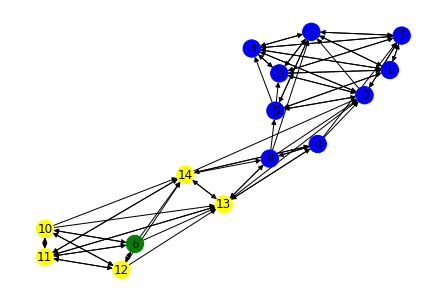

In [56]:
#graph predicted using proposed algorithm
import networkx as nx 
G = nx.DiGraph()
color_map=[]
for i in range(len(Y_tot)):
  G.add_node(i)
  if Y_tot[i]==-1:
    color_map.append("blue")
  elif Y_tot[i]==1:
    color_map.append("green")
  else:
    color_map.append("yellow")
for i in range(E.shape[0]): 
 for j in range(E.shape[1]): 
   if E[i][j] == 1: 
      G.add_edge(i,j) 
nx.draw( G ,node_color=color_map,with_labels=True) 
plt.show() 
